In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras as kr
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import talos

import matplotlib.pyplot as plt

In [2]:
# upload & joint
emb = np.load('/root/work/data/emb_stad_exp32_10.npy')
label = pd.read_csv('/root/work/data/STAD/label_met_stad')

emb_size = emb.shape[1]

In [3]:
label = label[:emb.shape[0]]

In [6]:
emb.shape

(10, 312640)

In [7]:
# data preprocessing
x = emb

# str -> int
y = np.array(label['Molecular.Subtype'].map({'CIN':0, 'GS':1, 'MSI':2, 'EBV':3}).astype(int))

# int -> onthot
def getOnehotLable(old_label):
    num_labels = old_label.shape[0]
    num_classes=5
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + old_label.ravel()] = 1
    return labels_one_hot
    
y = getOnehotLable(y)

In [8]:
seed = 2022
np.random.seed(seed)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=seed)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(7, 312640) (3, 312640) (7, 5) (3, 5)


In [9]:
model = Sequential()
model.add(Dense(2048, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(512,kernel_initializer='uniform',activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(128,kernel_initializer='uniform',activation='tanh'))
model.add(Dense(5,kernel_initializer='uniform',activation='softmax'))

model.compile(loss=kr.losses.CategoricalCrossentropy(), optimizer='sgd', metrics=['categorical_accuracy'])
sgd = optimizers.SGD(learning_rate=0.0001)

Epoch 1/20
1/1 [==============================] - 1s 698ms/step - loss: 0.5415 - categorical_accuracy: 0.7000
Epoch 2/20
1/1 [==============================] - 1s 551ms/step - loss: 0.3435 - categorical_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 1s 616ms/step - loss: 0.2722 - categorical_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 451ms/step - loss: 0.2336 - categorical_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 464ms/step - loss: 0.2062 - categorical_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 470ms/step - loss: 0.1872 - categorical_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 457ms/step - loss: 0.1732 - categorical_accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 454ms/step - loss: 0.1631 - categorical_accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 461ms/step - loss: 0.1543 - categorical_accuracy: 1.0000
Epoch 10/2

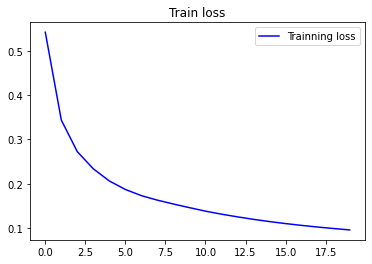

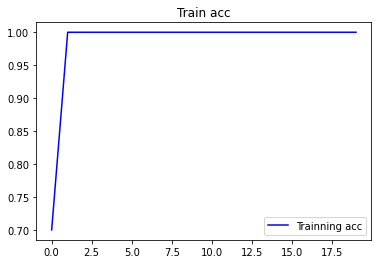

1/1 [==============================] - 0s 75ms/step - loss: 0.0969 - categorical_accuracy: 1.0000


In [11]:
b = 64
train_history=model.fit(x,
                        y,
                        epochs=20,
                        #validation_data=(test_x, test_y),
                        batch_size=b)

loss=train_history.history['loss']
acc=train_history.history['categorical_accuracy']
epochs=range(0,len(loss))
plt.title("Train loss")
plt.plot(epochs,loss,'b',label='Trainning loss')
# val_loss=train_history.history['val_loss']
# val_acc=train_history.history['val_categorical_accuracy']
# plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend(loc='best')
plt.figure()
plt.title("Train acc")
plt.plot(epochs,acc,'b',label='Trainning acc')
# plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend(loc='best')
plt.show()

scores=model.evaluate(test_x,test_y,batch_size=b)

In [ ]:
def model_16(train_x, train_y, test_x, test_y, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=train_x.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['second_neuron'],kernel_initializer='uniform',activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['thrid_neuron'],kernel_initializer='uniform',activation='relu'))
    model.add(Dense(4,kernel_initializer='uniform',activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy', talos.utils.metrics.f1score])
    sgd = optimizers.SGD(learning_rate=params['lr'])

    train_history=model.fit(train_x,
                            train_y,epochs=params['epochs'],
                            #validation_data=[test_x, test_y],
                            validation_split=0.1,
                            batch_size=params['batch_size'])

    return train_history, model 

In [ ]:
p = {'first_neuron': [1024, 2048],
     'second_neuron': [128, 256],
     'thrid_neuron':[0, 128],
     'dropout': [0, .2, .3],
     'lr':[.02, .01, .005, .001, .0001],
     'epochs': [20, 50, 100],
     'batch_size': [16, 32, 64, 96, 128]
     }

In [ ]:
out = talos.Scan(x=train_x, y=train_y, model=model_16, params=p, experiment_name='try_64') #, x_val=test_x, y_val=test_y

In [ ]:
hyperp = out.data
hyperp.to_csv('/root/work/data/hyp_16.csv')
